# Basic plotting using Matplotlib and Numpy Data

Before we get started, you may choose to run this notebook on LEAP-Pangeo hub or Binder!

<a href="https://leap.2i2c.cloud/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fm2lines%2Fdata-gallery&urlpath=lab%2Ftree%2Fdata-gallery%2Fsrc%2Fnotebooks%2Focean_surface_boundary.ipynb&branch=main"><img src="https://custom-icon-badges.demolab.com/badge/LEAP-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:30px;"></a>

<a href="https://mybinder.org/v2/gh/m2lines/data-gallery/main?labpath=src%2Fnotebooks%2Focean_surface_boundary.ipynb"><img src="https://custom-icon-badges.demolab.com/badge/Binder-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:28px;"></a>

This notebook is built on top of `Parameterizing Vertical Mixing Coefficients in the Ocean Surface Boundary Layer Using Neural Networks` by Dr. Akash Sane and [Basic Plotting with MOM6](MOM6_basic_plotting.ipynb).

## Introduction



In [7]:
import numpy as np
import numpy.ma as ma
import netCDF4 as ncd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import copy
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import cmocean as cmo
import matplotlib.pyplot as plt

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Recreating Figure 8: Total ocean heat content

We can observe that the ocean's total heat content is sensitive to the vertical diffusivity set by the ocean surface boundary layer mixing scheme. ePBL_NN replaces ad-hoc diffusivity of ePBL with a physics informed data-driven neural network.

In [8]:
time = np.loadtxt("data/OHC_time.txt")  # time , days since reference time
K = 273  # this value does not matter because we are only checking OHC anomaly w.r.t 1958
th_NN = np.loadtxt("data/OHC_th_NN.txt") + K  # ocean mean temperature ePBL_NN
th_ML1 = np.loadtxt("data/OHC_th_ML1.txt") + K  # ocean mean temperature ePBL \gamma = 1
th_ML3 = np.loadtxt("data/OHC_th_ML3.txt") + K  # ocean mean temperature ePBL \gamma = 1
masso_NN = np.loadtxt("data/OHC_masso_NN.txt")  # Integral_vol (rho*vol)  ePBL_NN
masso_ML1 = np.loadtxt(
    "data/OHC_masso_ML1.txt"
)  # Integral_vol (rho*vol)  ePBL \gamma = 1
masso_ML3 = np.loadtxt(
    "data/OHC_masso_ML3.txt"
)  # Integral_vol (rho*vol)  ePBL \gamma = 3

# ocean heat content

ohc_MLE1 = masso_ML1 * th_ML1 * 3850  # Joules
ohc_NN = masso_NN * th_NN * 3850  # - ohc_MLE1[0]  # Joules
ohc_MLE3 = masso_ML3 * th_ML3 * 3850  # - ohc_MLE1[0] # Joules


i = 35  # index of year 1993
# Rate of Warming:\
Area = 361255840000000.0  # Area of ocean obtained from MOM6 OM4 grid. Units: m^2
dt = (
    (time[i:]) * 24 * 60 * 60
)  # time array in seconds between 2003 and 2017. Units: seconds


def get_ohc(ohc, Area, dt):
    d_ohc = (ohc[i:]) / Area
    p = np.polyfit(dt, d_ohc, 1)

    p1 = np.polyfit(dt, ohc[i:], 1)
    linear = np.polyval(p1, dt)

    return ohc, p, linear


## ePBL_NN
ohc_NN, p_nn, linear_NN = get_ohc(ohc_NN, Area, dt)

ohc_MLE1, p_mle1, linear_MLE1 = get_ohc(ohc_MLE1, Area, dt)

ohc_MLE3, p_mle3, linear_MLE3 = get_ohc(ohc_MLE3, Area, dt)

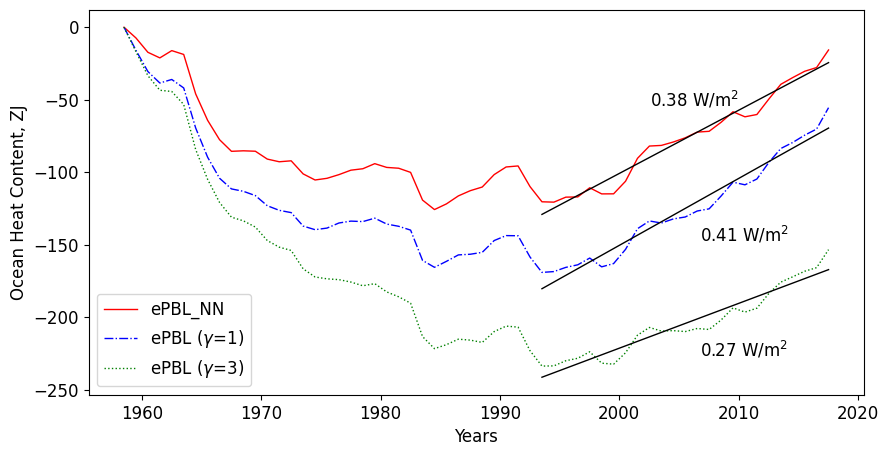

In [9]:
ii = 0
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["font.size"] = 12
plt.figure(figsize=(10, 5))
plt.plot(
    np.array(time) / 365 + 1958,
    (ohc_NN * 1e-21) - (ohc_NN * 1e-21)[ii],
    "r-",
    label="ePBL_NN",
)
plt.plot(
    np.array(time) / 365 + 1958,
    (ohc_MLE1 * 1e-21) - (ohc_MLE1 * 1e-21)[ii],
    "b-.",
    label=r"ePBL ($\gamma$=1)",
)
plt.plot(
    np.array(time) / 365 + 1958,
    (ohc_MLE3 * 1e-21) - (ohc_MLE3 * 1e-21)[ii],
    "g:",
    label=r"ePBL ($\gamma$=3)",
)

plt.plot(
    np.array(time[i:]) / 365 + 1958,
    (linear_NN * 1e-21) - (ohc_NN * 1e-21)[ii],
    color="k",
)
plt.plot(
    np.array(time[i:]) / 365 + 1958,
    (linear_MLE1 * 1e-21) - (ohc_MLE1 * 1e-21)[ii],
    color="k",
)
plt.plot(
    np.array(time[i:]) / 365 + 1958,
    (linear_MLE3 * 1e-21) - (ohc_MLE3 * 1e-21)[ii],
    color="k",
)

plt.annotate(
    str(np.around(p_mle3[0], 2)) + " W/m$^2$", (0.7, 0.2), xycoords="figure fraction"
)
plt.annotate(
    str(np.around(p_mle1[0], 2)) + " W/m$^2$", (0.7, 0.43), xycoords="figure fraction"
)
plt.annotate(
    str(np.around(p_nn[0], 2)) + " W/m$^2$", (0.65, 0.7), xycoords="figure fraction"
)

plt.xlabel("Years")
plt.ylabel("Ocean Heat Content, ZJ")
plt.legend()
plt.show();
# plt.savefig("ohc.pdf", format="pdf")

## Recreating Figure 9: Sea surface temperature and biases

In [10]:
cwd = os.getcwd()
wo = ncd.Dataset(cwd + "/data/tos_2003-2017/woa18_A5B7_t00_01.nc").variables["t_an"][
    0, 0, :, :
]  # World Ocean Atlas dataset

tos_NN1 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/NN/ocean_annual_z_1x1deg.2003-2007.thetao.nc"
).variables["thetao"][:, 0, :, :]
tos_NN2 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/NN/ocean_annual_z_1x1deg.2008-2012.thetao.nc"
).variables["thetao"][:, 0, :, :]
tos_NN3 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/NN/ocean_annual_z_1x1deg.2013-2017.thetao.nc"
).variables["thetao"][:, 0, :, :]

tos_ML1 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/MLE1/ocean_annual_z_1x1deg.2003-2007.thetao.nc"
).variables["thetao"][:, 0, :, :]
tos_ML2 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/MLE1/ocean_annual_z_1x1deg.2008-2012.thetao.nc"
).variables["thetao"][:, 0, :, :]
tos_ML3 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/MLE1/ocean_annual_z_1x1deg.2013-2017.thetao.nc"
).variables["thetao"][:, 0, :, :]

case = "MLE1"
t1 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/" + case + "/ocean_annual_z_1x1deg.2003-2007.thetao.nc"
).variables["time"][:]
t2 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/" + case + "/ocean_annual_z_1x1deg.2008-2012.thetao.nc"
).variables["time"][:]
t3 = ncd.Dataset(
    cwd + "/data/tos_2003-2017/" + case + "/ocean_annual_z_1x1deg.2013-2017.thetao.nc"
).variables["time"][:]


time = np.zeros(15)
time[0:5] = t1
time[5:10] = t2
time[10:15] = t3

d = ncd.Dataset(cwd + "/data/tos_2003-2017/woa18_A5B7_t00_01.nc").variables
x = d["lon"][:]
y = d["lat"][:]
lon, lat = np.meshgrid(x, y)

mom_mask = ma.getmask(tos_NN1[0, :, :])
wo_mask = ma.getmask(wo)

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/shubham/Documents/workspace/data-gallery/src/notebooks/data/tos_2003-2017/woa18_A5B7_t00_01.nc'

In [ ]:
tos_NN = np.zeros([13, 180, 360])
tos_ML = np.zeros([13, 180, 360])

tos_NN = np.concatenate([tos_NN1[2:, :, :], tos_NN2[:, :, :], tos_NN3[:, :, :]], axis=0)
# tos_NN[tos_NN>1000]=np.nan

tos_ML = np.concatenate([tos_ML1[2:, :, :], tos_ML2[:, :, :], tos_ML3[:, :, :]], axis=0)
# tos_ML[tos_ML>1000]=np.nan

tos_NN_av = np.mean(tos_NN, axis=0)
tos_ML_av = np.mean(tos_ML, axis=0)

tmp1 = copy.deepcopy(tos_NN_av)
tos_NN_av[:, 0:180] = tmp1[:, 180:360]
tos_NN_av[:, 180:360] = tmp1[:, 0:180]

tmp2 = copy.deepcopy(tos_ML_av)
tos_ML_av[:, 0:180] = tmp2[:, 180:360]
tos_ML_av[:, 180:360] = tmp2[:, 0:180]

wo_mask = ma.getmask(wo)


mom_temp = np.zeros(np.shape(tos_NN1[0, :, :]))
mom_mask = np.zeros([180, 360])

tmp1 = copy.deepcopy(mom_mask)
mom_mask[:, 0:180] = tmp1[:, 180:360]
mom_mask[:, 180:360] = tmp1[:, 0:180]

wo_mask = wo_mask.astype(int)
mom_mask = mom_mask.astype(int)

common_mask = wo_mask * mom_mask * 1000

tos_NN_av = tos_NN_av + common_mask
tos_ML_av = tos_ML_av + common_mask
wo = wo.data + common_mask

tos_NN_av[tos_NN_av > 10000] = np.nan
tos_ML_av[tos_ML_av > 10000] = np.nan
wo[wo > 10000] = np.nan

wo = wo - tos_NN_av + tos_NN_av
tos_NN_av = tos_NN_av + wo - wo
tos_ML_av = tos_ML_av + wo - wo

In [ ]:
def plot_mlds(mod_e, mod_n, obs):

    # mod_e = model ePBL
    # mod_n = model ePBL_NN
    # obs = ARGO data
    # case = summer or winter
    # mld_criterion = PE or DE, PE stands for potential anomaly, DE stands for 0.03 kg/m3 MLD criterion

    vmin1 = 0.0
    vmax1 = 80.0
    vmin2 = -10.0
    vmax2 = 10.0
    vmin3 = -10.0
    vmax3 = 10.0

    plot_no = [1, 2, 3, 4]

    fig = plt.figure(figsize=(15, 8), layout="constrained")
    plt.rcParams["font.size"] = 15

    for i in plot_no:

        # i=1

        ax = fig.add_subplot(2, 2, i, projection=ccrs.Robinson(central_longitude=-60))
        ax.add_feature(cfeature.LAND, color="gray")
        # gl = gridlines = ax.gridlines(draw_labels=True, linewidth=0,alpha=0.5, linestyle='--')

        gl = ax.gridlines(draw_labels=True, linewidth=0.01, alpha=0.0, linestyle="--")

        # gl.xtop_labels = False
        gl.xlabels_top = False
        gl.ylabels_right = False
        # gl = ax.gridlines()

        if i == 1:
            data = mod_e  ### load the data to be plotted
            cmap = plt.cm.YlOrBr
            vmin, vmax, ci = -2.0, 32, 2.0
            cilev = np.arange(vmin - ci, vmax + ci * 2, ci)
            norm = plt.matplotlib.colors.BoundaryNorm(boundaries=cilev, ncolors=cmap.N)

            pcm = ax.pcolormesh(
                lon,
                lat,
                data,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                rasterized=True,
            )

            ax.set_title("(a) ePBL_NN")
            cbar = plt.colorbar(
                pcm,
                ax=ax,
                orientation="vertical",
                shrink=0.8,
                pad=0.05,
                location="right",
            )
            cbar.set_label("$\degree $C")

        elif i == 2:
            data = mod_n - mod_e  ### load the data to be plotted
            rmse = np.around(np.sqrt(np.nanmean(data**2)), 3)
            cmap = plt.cm.PuOr_r

            vmin, vmax, ci = -1.5, 1.5, 0.25
            cilev = np.arange(vmin - ci, vmax + ci * 2, ci)
            norm = plt.matplotlib.colors.BoundaryNorm(boundaries=cilev, ncolors=cmap.N)

            pcm = ax.pcolormesh(
                lon,
                lat,
                data,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                rasterized=True,
            )

            ax.set_title(r"(a) ePBL_NN - ePBL, RMSE=" + str(rmse) + " $\degree $C")
            cbar = plt.colorbar(
                pcm,
                ax=ax,
                orientation="vertical",
                shrink=0.8,
                pad=0.05,
                location="right",
            )
            cbar.set_label("$\degree $C")

        elif i == 3:
            data = mod_e - obs  ### load the data to be plotted
            rmse = np.around(np.sqrt(np.nanmean(data**2)), 3)
            cmap = plt.cm.coolwarm

            vmin, vmax, ci = -4.0, 4.0, 0.5
            cilev = np.arange(vmin - ci, vmax + ci * 2, ci)
            norm = plt.matplotlib.colors.BoundaryNorm(boundaries=cilev, ncolors=cmap.N)

            pcm = ax.pcolormesh(
                lon,
                lat,
                data,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                rasterized=True,
            )
            ax.set_title(r"(a) ePBL - Obs, RMSE=" + str(rmse) + " $\degree $C")
            cbar.set_label("$\degree $C")

        elif i == 4:
            data = mod_n - obs  ### load the data to be plotted
            rmse = np.around(np.sqrt(np.nanmean(data**2)), 3)
            cmap = plt.cm.coolwarm
            vmin, vmax, ci = -4.0, 4.0, 0.5
            cilev = np.arange(vmin - ci, vmax + ci * 2, ci)
            norm = plt.matplotlib.colors.BoundaryNorm(boundaries=cilev, ncolors=cmap.N)

            pcm = ax.pcolormesh(
                lon,
                lat,
                data,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                rasterized=True,
            )
            ax.set_title(r"(a) ePBL_NN - ARGO, RMSE=" + str(rmse) + " $\degree $C")

            cbar = plt.colorbar(
                pcm,
                ax=ax,
                orientation="vertical",
                shrink=0.8,
                pad=0.05,
                location="right",
            )
            cbar.set_label("$\degree $C")

        ax.set_extent([-180.0, 180.0, -90.0, 90.0], crs=ccrs.PlateCarree())
        ax.set_global()
        # cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, pad=0.05, location="right")
        # cbar.set_label('metres')

    return fig

In [ ]:
mod_e, mod_n, obs = tos_ML_av, tos_NN_av, wo

fig1 = plot_mlds(mod_e, mod_n, obs)
plt.suptitle(r"SST and SST Bias, 2005-2017 averaged ($\degree $C)");